In [38]:
# import sys
# sys.path.append('C:/Users/Home/Desktop/IL-NIQE-1.0.1/')
 
# from ILNIQE import calculate_ilniqe

In [1]:
# img=cv2.imread(img_path)
# cv2.imshow('rgb_image', img)
# cv2.waitKey(0) 
# cv2.destroyAllWindows()

from scipy.stats import spearmanr, pearsonr

In [8]:
import cv2

img_path = "C:/Users/Home/Desktop/IQA/niqemaster/test_imgs/bikes.bmp"
img_path2 ="C:/Users/Home/Desktop/IQA/niqemaster/test_imgs/bikes_distorted.bmp"

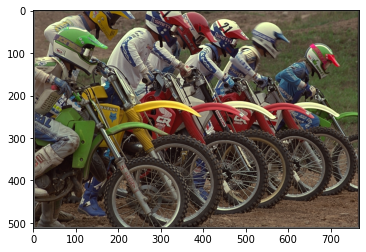

In [3]:
import matplotlib.pyplot as plt
img_color = plt.imread(img_path)
plt.imshow(img_color)
plt.show()

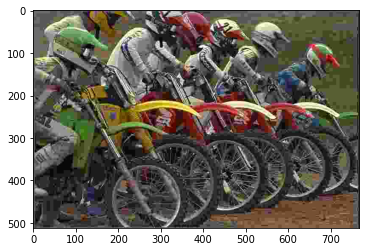

In [4]:
import matplotlib.pyplot as plt
img_color = plt.imread(img_path2)
plt.imshow(img_color)
plt.show()

- NR-Metric

In [39]:
#IL_NIQE

In [2]:

def ILNIQE(img_path):
    from IL_NIQE.ILNIQE import calculate_ilniqe
    import cv2
    import warnings
    import time
    img = cv2.imread(img_path)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        time_start = time.time()

        niqe_result = calculate_ilniqe(img, 0, input_order='HWC', resize=True, version='python')

        time_used = time.time() - time_start
    return niqe_result
    #print(f'\t time used in sec: {time_used:.4f}')

In [105]:
ILNIQE(img_path)

17.99771209224426

In [ ]:
#BRISQE

In [3]:
def BRISQUE(img_path):
    from brisque import BRISQUE

    obj = BRISQUE(img_path, url=False)
    return obj.score()


In [107]:
BRISQUE(img_path)

5.123779018017757

In [ ]:
#NIQE

In [4]:
def NIQE(img_path):
    import numpy as np
    from PIL import Image
    from niqemaster import niqemain
    ref = np.array(Image.open(img_path).convert('LA'))[:,:,0] # ref
    #dis = np.array(Image.open('C:/Users/Home/Desktop/IQA/niqemaster/test_imgs/bikes_distorted.bmp').convert('LA'))[:,:,0] # dis

    return niqemain.niqemain(ref)
    #print('NIQE of dis bikes image is: %0.3f'% niqemain.niqemain(dis))

In [99]:
NIQE(img_path)

13.604359805633935

In [3]:
# print(dir(niqemain))

['Image', 'PIL', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_get_patches_generic', '_niqe_extract_subband_feats', 'aggd_features', 'compute_image_mscn_transform', 'dirname', 'extract_on_patches', 'gen_gauss_window', 'get_patches_test_features', 'get_patches_train_features', 'ggd_features', 'join', 'math', 'niqemain', 'np', 'paired_product', 'scipy', 'skimage']


In [6]:
def CNNIQA(img_path, models='C:/Users/Home/Desktop/IQA/CNNIQA/models/CNNIQA-LIVE'):
    from CNNIQA.test_demo import CNNIQAnet
    from CNNIQA.IQADataset import NonOverlappingCropPatches
    import torch
    from PIL import Image
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNNIQAnet(ker_size=7,
                      n_kers=50,
                      n1_nodes=800,
                      n2_nodes=800).to(device)

    model.load_state_dict(torch.load(models, map_location=torch.device('cpu')))

    im = Image.open(img_path).convert('L')
    patches = NonOverlappingCropPatches(im, 32, 32)

    model.eval()
    with torch.no_grad():
        patch_scores = model(torch.stack(patches).to(device))
        return patch_scores.mean().item()

In [9]:
CNNIQA(img_path)

15.340015411376953

In [ ]:
#cpbd : CPBD is a perceptual-based no-reference objective image sharpness metric based on the cumulative probability of blur detection developed at the Image, Video and Usability Laboratory of Arizona State University.

In [10]:
def CPBD(img_path):
    from imageio import imread
    import cv2
    import cpbd
    import imageio.v3 as iio
    input_image = iio.imread(img_path)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    return cpbd.compute(input_image)
    

In [47]:
CPBD(img_path)

0.7202435661764706

In [3]:
CPBD(img_path2)

0.5501298350925707


In [ ]:
#hyperIQA

In [1]:
import torch
import torchvision
import hyperIQA.models
from PIL import Image
import numpy as np


In [2]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [3]:


def hyperIQA(img_path):
    import torch
    import torchvision
    from hyperIQA import models
    from PIL import Image
    import numpy as np
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model_hyper = models.HyperNet(16, 112, 224, 112, 56, 28, 14, 7).to(device)
    model_hyper.train(False)
    # load our pre-trained model on the koniq-10k dataset
    model_hyper.load_state_dict((torch.load('C:/Users/Home/Desktop/IQA/hyperIQA/pretrained/koniq_pretrained.pkl', map_location=device)))

    transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize((512, 384)),
                        torchvision.transforms.RandomCrop(size=224),
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                        std=(0.229, 0.224, 0.225))])

    # random crop 10 patches and calculate mean quality score
    pred_scores = []
    for i in range(10):
        img = pil_loader(img_path)
        img = transforms(img)
        img = torch.tensor(img).unsqueeze(0)
        paras = model_hyper(img)  # 'paras' contains the network weights conveyed to target network

        # Building target network
        model_target = models.TargetNet(paras).to(device)
        for param in model_target.parameters():
            param.requires_grad = False

        # Quality prediction
        pred = model_target(paras['target_in_vec'])  # 'paras['target_in_vec']' is the input to target net
        pred_scores.append(float(pred.item()))
    score = np.mean(pred_scores)
    # quality score ranges from 0-100, a higher score indicates a better quality
    # print('Predicted quality score: %.2f' % score)
    return score


----------------------------------------------------------------------------------------

- Blur 처리된 이미지 데이터 추출

In [19]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

In [5]:
path = "E:/24team/kadid10k/images"

In [7]:
mos = pd.read_csv("E:/24team/kadid10k/dmos.csv")

In [8]:
mos

,dist_img,ref_img,dmos,var
0,I01_01_01.png,I01.png,4.57,0.496
1,I01_01_02.png,I01.png,4.33,0.869
2,I01_01_03.png,I01.png,2.67,0.789
3,I01_01_04.png,I01.png,1.67,0.596
4,I01_01_05.png,I01.png,1.10,0.300
...,...,...,...,...
10120,I81_25_01.png,I81.png,3.33,0.789
10121,I81_25_02.png,I81.png,3.73,0.772
10122,I81_25_03.png,I81.png,4.30,0.526
10123,I81_25_04.png,I81.png,4.13,0.499


In [ ]:
#*_01(02,03)_*.png 가지가 블러처리된 이미지임

In [9]:
mos123=mos[mos['dist_img'].str.contains("_01_|_02_|_03_", na=False)] # _01_ _02_ _03_ 만 블러처리된이미지므로 추출

In [10]:
mos123.head(20), len(mos123) #제대로 분류되었는지 확인 1215개로 줄어듬

(          dist_img  ref_img  dmos    var
 0    I01_01_01.png  I01.png  4.57  0.496
 1    I01_01_02.png  I01.png  4.33  0.869
 2    I01_01_03.png  I01.png  2.67  0.789
 3    I01_01_04.png  I01.png  1.67  0.596
 4    I01_01_05.png  I01.png  1.10  0.300
 5    I01_02_01.png  I01.png  3.83  0.860
 6    I01_02_02.png  I01.png  2.27  0.772
 7    I01_02_03.png  I01.png  1.53  0.670
 8    I01_02_04.png  I01.png  1.23  0.418
 9    I01_02_05.png  I01.png  1.20  0.400
 10   I01_03_01.png  I01.png  4.73  0.442
 11   I01_03_02.png  I01.png  3.97  0.657
 12   I01_03_03.png  I01.png  2.70  0.936
 13   I01_03_04.png  I01.png  2.03  0.795
 14   I01_03_05.png  I01.png  1.50  0.500
 125  I02_01_01.png  I02.png  4.50  0.719
 126  I02_01_02.png  I02.png  4.17  0.934
 127  I02_01_03.png  I02.png  2.07  0.772
 128  I02_01_04.png  I02.png  1.57  0.496
 129  I02_01_05.png  I02.png  1.27  0.512,
 1215)

In [11]:
mos=mos123 #편한 TEST를 위해 다시 mos로 바꿔줌

In [ ]:
# ILNIQE

In [182]:
dist_ILNIQE_num = []
dist_MOS_num = []


for i in tqdm(range(800,900)):
    dist = os.path.join(path, mos.iloc[i, 0])
    mos_num = mos.iloc[i, 2]
    dist_ILNIQE_num.append((round(ILNIQE(dist),3)))
    dist_MOS_num.append(mos_num)

100%|██████████| 100/100 [3:12:03<00:00, 115.24s/it] 


In [36]:
spearmanr(dist_ILNIQE_num, dist_MOS_num)

SpearmanrResult(correlation=-0.8698090996654677, pvalue=6.6298138997324975e-155)

In [37]:
pearsonr(dist_ILNIQE_num, dist_MOS_num)

(-0.7702807361524955, 2.325494433513447e-99)

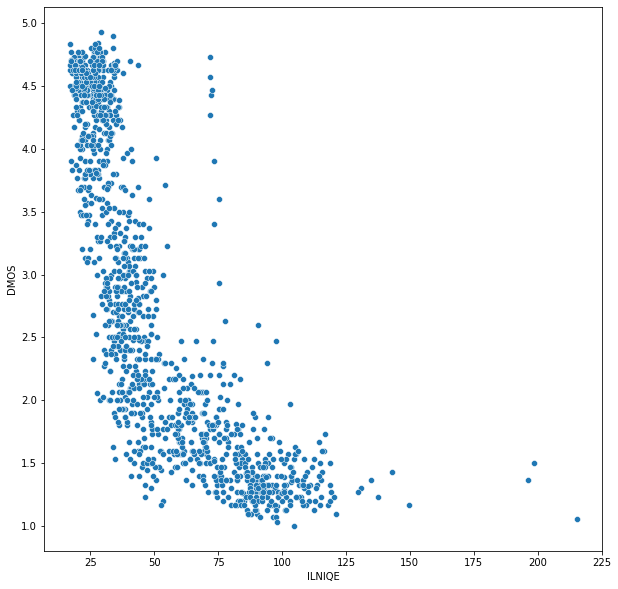

In [370]:
plt.figure(figsize = (10,10))
sns.scatterplot(x = NRIQA_df_last['ILNIQE'], y = NRIQA_df_last['DMOS'])
plt.show()

In [ ]:
# CNNIQA with spearmanr, pearsonr

In [17]:
dist_CNNIQA_num = []
dist_MOS_num = []


for i in tqdm(range(len(mos))):
    dist = os.path.join(path, mos.iloc[i, 0])
    mos_num = mos.iloc[i, 2]
    dist_CNNIQA_num.append((round(CNNIQA(dist),3)))
    dist_MOS_num.append(mos_num)

100%|██████████| 1215/1215 [04:46<00:00,  4.25it/s]


In [18]:
spearmanr(dist_CNNIQA_num, dist_MOS_num)

SpearmanrResult(correlation=-0.7640065036239475, pvalue=4.393391634995857e-233)

In [19]:
pearsonr(dist_CNNIQA_num, dist_MOS_num)

(-0.7520504169580238, 7.512818490253071e-222)

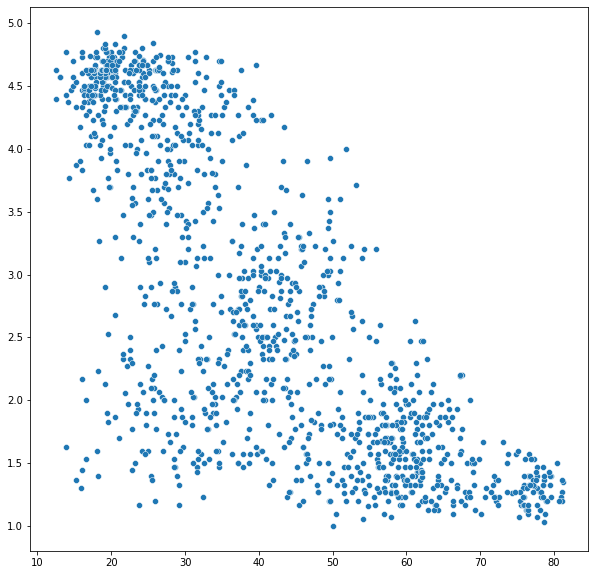

In [20]:
plt.figure(figsize = (10,10))
sns.scatterplot(x = dist_CNNIQA_num, y = dist_MOS_num)
plt.show()

In [ ]:
# BRISQUE with spearmanr, pearsonr

In [22]:
dist_BRISQUE_num = []
dist_MOS_num = []


for i in tqdm(range(len(mos))):
    dist = os.path.join(path, mos.iloc[i, 0])
    mos_num = mos.iloc[i, 2]
    dist_BRISQUE_num.append((round(BRISQUE(dist),3)))
    dist_MOS_num.append(mos_num)

100%|██████████| 1215/1215 [09:04<00:00,  2.23it/s]


In [23]:
spearmanr(dist_BRISQUE_num, dist_MOS_num)

SpearmanrResult(correlation=-0.7951079389722746, pvalue=1.0120631512118097e-265)

In [24]:
pearsonr(dist_BRISQUE_num, dist_MOS_num)

(-0.7801015108025544, 2.630774504424098e-249)

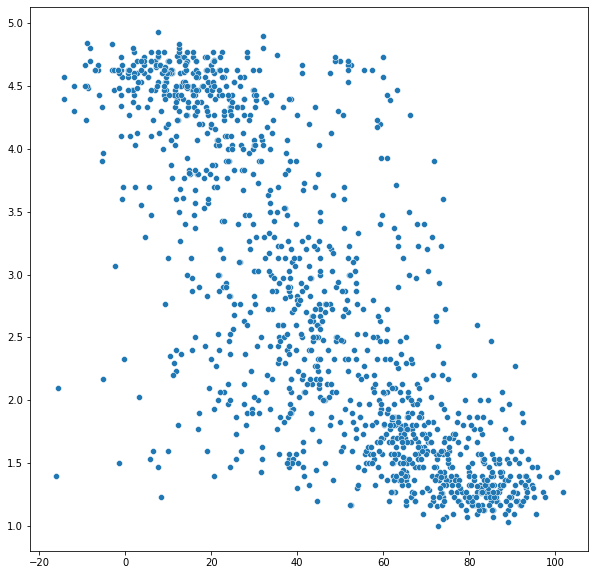

In [25]:
plt.figure(figsize = (10,10))
sns.scatterplot(x = dist_BRISQUE_num, y = dist_MOS_num)
plt.show()

In [ ]:
#NIQE with spearmanr, pearsonr

In [27]:
dist_NIQE_num = []
dist_MOS_num = []


for i in tqdm(range(len(mos))):
    dist = os.path.join(path, mos.iloc[i, 0])
    mos_num = mos.iloc[i, 2]
    dist_NIQE_num.append((round(NIQE(dist),3)))
    dist_MOS_num.append(mos_num)

100%|██████████| 1215/1215 [08:48<00:00,  2.30it/s]


In [28]:
spearmanr(dist_NIQE_num, dist_MOS_num)

SpearmanrResult(correlation=-0.46089220267349873, pvalue=6.2688181178290745e-65)

In [29]:
pearsonr(dist_NIQE_num, dist_MOS_num)

(-0.42161321982013855, 1.5161897646821445e-53)

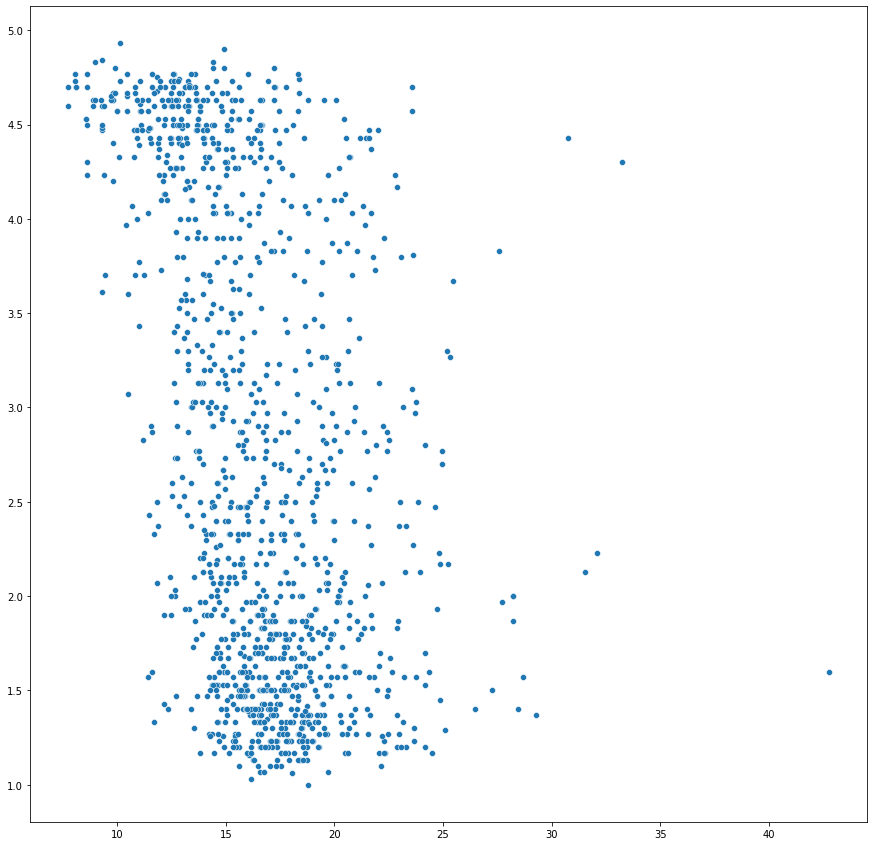

In [30]:
plt.figure(figsize = (15,15))
sns.scatterplot(x = dist_NIQE_num, y = dist_MOS_num)
plt.show()

In [ ]:
#CPBD with spearmanr, pearsonr

In [31]:
dist_CPBD_num = []
dist_MOS_num = []


for i in tqdm(range(len(mos))):
    dist = os.path.join(path, mos.iloc[i, 0])
    mos_num = mos.iloc[i, 2]
    dist_CPBD_num.append((round(CPBD(dist),3)))
    dist_MOS_num.append(mos_num)
    

100%|██████████| 1215/1215 [31:01<00:00,  1.53s/it] 


In [32]:
spearmanr(dist_CPBD_num, dist_MOS_num)

SpearmanrResult(correlation=0.7909811803319112, pvalue=4.504898641825933e-261)

In [33]:
pearsonr(dist_CPBD_num, dist_MOS_num)

(0.7667202314711199, 9.994001505639944e-236)

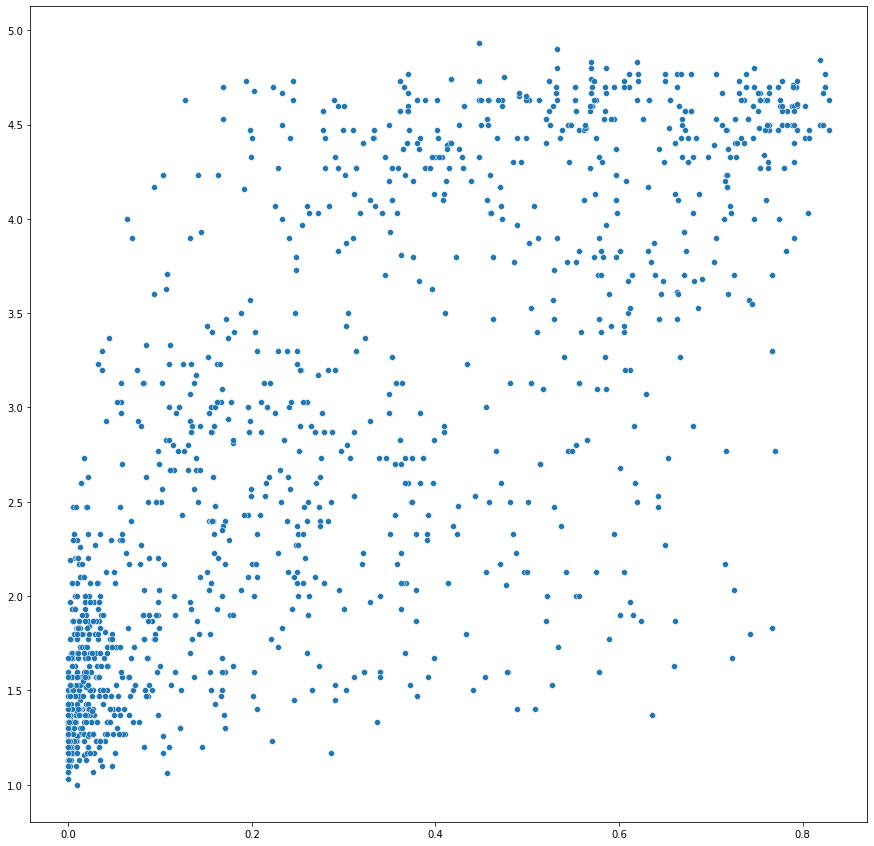

In [34]:
plt.figure(figsize = (15,15))
sns.scatterplot(x = dist_CPBD_num, y = dist_MOS_num)
plt.show()

In [109]:
len(dist_CPBD_num)

5000

In [ ]:
#hyperIQA 점수가 높을 수록 좋은 이미지

In [27]:
dist_hyperIQA_num = []
dist_MOS_num = []


for i in tqdm(range(len(mos))):
    dist = os.path.join(path, mos.iloc[i, 0])
    mos_num = mos.iloc[i, 2]
    dist_hyperIQA_num.append((round(hyperIQA(dist),3)))
    dist_MOS_num.append(mos_num)

  0%|          | 0/1215 [00:00<?, ?it/s]C:\Users\Home\AppData\Local\Temp\ipykernel_24140\1431389917.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).unsqueeze(0)
100%|██████████| 1215/1215 [2:31:54<00:00,  7.50s/it] 


In [28]:
spearmanr(dist_hyperIQA_num, dist_MOS_num)

SpearmanrResult(correlation=0.7840413119669716, pvalue=1.7308169969158934e-253)

In [29]:
pearsonr(dist_hyperIQA_num, dist_MOS_num)

(0.8310984274631997, 2.160639925179e-311)

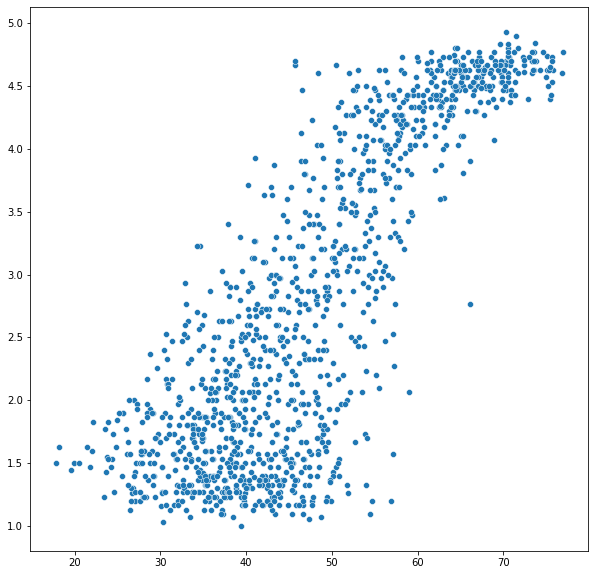

In [39]:
plt.figure(figsize = (10,10))
sns.scatterplot(x = dist_hyperIQA_num, y = dist_MOS_num)
plt.show()

In [ ]:
# ffhq 데이터 gau

In [17]:
import os
import tqdm

In [13]:
path='E:/24team/gaussian/'

In [14]:
gaussian_list=os.listdir(path)

In [15]:
len(gaussian_list)

6000

In [20]:
dist_hyper_num = []
# dist_MOS_num = []


for i in tqdm(range(len(gaussian_list))):
    dist = os.path.join(path, gaussian_list[i])
    
    dist_hyper_num.append((round(hyperIQA(dist),3)))

  0%|          | 0/6000 [00:00<?, ?it/s]C:\Users\Home\AppData\Local\Temp\ipykernel_25040\1431389917.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).unsqueeze(0)
100%|██████████| 6000/6000 [12:25:06<00:00,  7.45s/it]  


In [21]:
dist_hyper_num

[74.136,
 72.22,
 62.942,
 45.001,
 40.148,
 68.214,
 66.793,
 54.312,
 42.205,
 38.804,
 78.03,
 74.235,
 65.497,
 51.105,
 40.692,
 71.615,
 69.831,
 59.108,
 45.8,
 41.543,
 56.454,
 53.802,
 43.287,
 33.823,
 35.645,
 46.856,
 43.776,
 43.032,
 40.125,
 40.555,
 57.618,
 55.896,
 47.71,
 41.009,
 42.561,
 75.913,
 73.148,
 61.347,
 46.346,
 41.691,
 72.772,
 69.351,
 60.324,
 46.494,
 41.431,
 76.166,
 72.62,
 58.747,
 43.197,
 34.695,
 67.687,
 65.254,
 56.363,
 43.822,
 39.015,
 74.059,
 69.708,
 55.378,
 41.34,
 38.28,
 65.332,
 60.532,
 50.054,
 40.402,
 37.893,
 59.702,
 55.881,
 47.428,
 42.152,
 37.716,
 66.507,
 61.969,
 50.855,
 41.222,
 36.782,
 59.026,
 55.494,
 48.299,
 40.173,
 38.444,
 71.995,
 66.721,
 55.436,
 38.108,
 36.77,
 63.146,
 56.991,
 48.445,
 37.621,
 36.581,
 72.05,
 67.739,
 56.116,
 41.339,
 32.628,
 68.745,
 67.658,
 55.04,
 42.018,
 34.738,
 42.225,
 39.938,
 39.283,
 34.187,
 38.111,
 64.849,
 60.671,
 49.851,
 39.215,
 35.435,
 59.599,
 53.937,
 46

In [36]:
NRIQA_df_ffhq_gau=pd.read_csv("C:/Users/Home/Desktop/IQA/NRIQA_df_ffhq_gau.csv")

In [37]:
NRIQA_df_ffhq_gau

,CPBD,NIQE,BRISQUE,CNNIQA,HYPER,WaDIQaM_LIVE,DIQaM_LIVE,WaDIQaM_TID,DIQaM_TID
0,0.035,14.864,76.643,61.500,74.136,69.789,71.897,77.053,67.926
1,0.234,14.790,56.684,47.998,72.220,59.054,59.304,66.042,55.366
2,0.440,11.608,15.740,16.397,62.942,71.219,65.756,70.592,62.953
3,0.000,17.399,95.894,77.725,45.001,21.404,23.330,36.444,29.563
4,0.611,7.479,-3.795,13.307,40.148,59.486,58.296,56.054,54.335
...,...,...,...,...,...,...,...,...,...
5995,0.656,13.638,3.786,12.120,73.569,7.109,28.182,37.926,33.584
5996,0.020,14.180,73.307,60.744,70.599,21.599,25.858,30.743,29.293
5997,0.020,17.697,68.301,61.628,60.573,6.236,32.725,37.837,32.131
5998,0.004,14.120,72.814,63.677,50.147,8.867,19.567,31.541,21.568


In [34]:
NRIQA_df_ffhq_gau=NRIQA_df_ffhq_gau[['CPBD', 'NIQE', 'BRISQUE', 'CNNIQA', 'HYPER', 'WaDIQaM_LIVE', 'DIQaM_LIVE',
       'WaDIQaM_TID', 'DIQaM_TID']]

In [35]:
NRIQA_df_ffhq_gau.to_csv("NRIQA_df_ffhq_gau.csv", index=False)

- NRIQA_DataFrame 만들기

In [41]:
import pandas as pd

In [50]:
NRIQA_df=pd.DataFrame({'CPBD': dist_CPBD_num,
             'NIQE': dist_NIQE_num,
             'BRISQUE' : dist_BRISQUE_num,
             'CNNIQA' : dist_CNNIQA_num,})
             #'ILNIQE' : dist_ILNIQE_num,
             #'MOS': dist_MOS_num})
             

In [36]:
NRIQA_df_last.to_csv("NRIQA_df_last.csv", mode='w',index=False) #CSV로 저장하기

In [285]:
# NRIQA_df_concat.loc[800:899,'ILNIQE']=   #자료 보충

In [38]:
NRIQA_df_last= pd.read_csv("C:/Users/Home/Desktop/IQA/NRIQA_df_last.csv")

In [337]:
NRIQA_df_last.isna().sum()

CPBD        0
NIQE        0
BRISQUE     0
CNNIQA      0
ILNIQE      0
DMOS        0
DIST_IMG    0
dtype: int64

In [39]:
NRIQA_df_last

,CPBD,NIQE,BRISQUE,CNNIQA,ILNIQE,HYPER,WaDIQaM_LIVE,DIQaM_LIVE,WaDIQaM_TID,DIQaM_TID,DMOS,DIST_IMG
0,0.524,15.288,18.468,17.725,22.025,67.377,7.515,29.026,34.108,35.453,4.57,I01_01_01.png
1,0.407,16.106,26.225,21.482,24.490,59.614,26.515,35.895,33.785,35.580,4.33,I01_01_02.png
2,0.131,18.836,50.731,43.691,36.201,42.574,44.362,47.225,43.473,37.948,2.67,I01_01_03.png
3,0.005,18.813,70.424,61.468,59.741,38.503,56.649,58.178,58.608,40.670,1.67,I01_01_04.png
4,0.000,17.540,90.263,78.708,90.068,43.387,52.663,65.557,78.039,36.814,1.10,I01_01_05.png
...,...,...,...,...,...,...,...,...,...,...,...,...
1210,0.586,9.889,1.867,24.134,28.267,64.626,50.081,28.706,44.715,46.724,4.80,I81_03_01.png
1211,0.430,16.853,14.119,31.408,28.785,52.423,44.000,33.874,47.563,48.657,4.27,I81_03_02.png
1212,0.472,20.821,28.383,40.116,35.516,40.440,48.820,42.019,54.019,53.369,2.60,I81_03_03.png
1213,0.104,18.558,54.815,41.899,47.930,34.846,54.851,43.308,58.022,53.953,2.17,I81_03_04.png


- 상관관계분석

In [42]:
def correlation(model):
    from scipy.stats import spearmanr, pearsonr
    print(model, 'DMOS (SROCC LCC)')
    print('---------------------')
    print(spearmanr(NRIQA_df_last[model], NRIQA_df_last['DMOS']))
    print("PearsonrResult",pearsonr(NRIQA_df_last[model], NRIQA_df_last['DMOS']))

In [281]:
correlation('CPBD')

CPBD DMOS (SROCC LCC)
---------------------
SpearmanrResult(correlation=0.7909811803319112, pvalue=4.504898641825933e-261)
PearsonrResult (0.7667202314711199, 9.994001505639944e-236)


In [282]:
correlation('NIQE')

NIQE DMOS (SROCC LCC)
---------------------
SpearmanrResult(correlation=-0.46089220267349873, pvalue=6.2688181178290745e-65)
PearsonrResult (-0.42161321982013855, 1.5161897646821445e-53)


In [283]:
correlation('BRISQUE')

BRISQUE DMOS (SROCC LCC)
---------------------
SpearmanrResult(correlation=-0.7951079389722746, pvalue=1.0120631512118097e-265)
PearsonrResult (-0.7801015108025544, 2.630774504424098e-249)


In [284]:
correlation('ILNIQE')

ILNIQE DMOS (SROCC LCC)
---------------------
SpearmanrResult(correlation=-0.8806693173397651, pvalue=0.0)
PearsonrResult (-0.788564761644563, 2.1233556887631987e-258)


In [44]:
correlation('DIQaM_LIVE') 

DIQaM_LIVE DMOS (SROCC LCC)
---------------------
SpearmanrResult(correlation=-0.7118149675170315, pvalue=2.4517914246891213e-188)
PearsonrResult (-0.7046017497472329, 6.213327005474444e-183)


In [50]:
correlation('WaDIQaM_TDI')

WaDIQaM_TDI DMOS (SROCC LCC)
---------------------
SpearmanrResult(correlation=-0.7159718291312673, pvalue=1.580493494174746e-191)
PearsonrResult (-0.6957793284401369, 1.5259155080614529e-176)


In [43]:
correlation('HYPER')

HYPER DMOS (SROCC LCC)
---------------------
SpearmanrResult(correlation=0.7840413119669716, pvalue=1.7308169969158934e-253)
PearsonrResult (0.8310984274631997, 2.160639925179e-311)


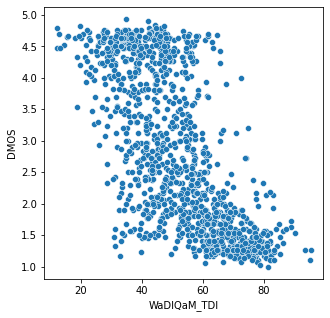

In [52]:
plt.figure(figsize = (5,5))
sns.scatterplot(x = NRIQA_df_last['WaDIQaM_TDI'], y = NRIQA_df_last['DMOS'])
plt.show()

In [286]:
# NIQE 를 제외하고 대체적으로 DMOS 지표와의 뚜렷한 상관관계를 나타내고 있음

- NRIQA_df_last 살펴보기

In [70]:
NRIQA_df_last= pd.read_csv("C:/Users/Home/Desktop/IQA/NRIQA_df_last.csv")

In [71]:
NRIQA_df_last

,CPBD,NIQE,BRISQUE,CNNIQA,ILNIQE,WaDIQaM_LIVE,DIQaM_LIVE,WaDIQaM_TID,DIQaM_TID,DMOS,DIST_IMG
0,0.524,15.288,18.468,17.725,22.025,7.515,29.026,34.108,35.453,4.57,I01_01_01.png
1,0.407,16.106,26.225,21.482,24.490,26.515,35.895,33.785,35.580,4.33,I01_01_02.png
2,0.131,18.836,50.731,43.691,36.201,44.362,47.225,43.473,37.948,2.67,I01_01_03.png
3,0.005,18.813,70.424,61.468,59.741,56.649,58.178,58.608,40.670,1.67,I01_01_04.png
4,0.000,17.540,90.263,78.708,90.068,52.663,65.557,78.039,36.814,1.10,I01_01_05.png
...,...,...,...,...,...,...,...,...,...,...,...
1210,0.586,9.889,1.867,24.134,28.267,50.081,28.706,44.715,46.724,4.80,I81_03_01.png
1211,0.430,16.853,14.119,31.408,28.785,44.000,33.874,47.563,48.657,4.27,I81_03_02.png
1212,0.472,20.821,28.383,40.116,35.516,48.820,42.019,54.019,53.369,2.60,I81_03_03.png
1213,0.104,18.558,54.815,41.899,47.930,54.851,43.308,58.022,53.953,2.17,I81_03_04.png


In [43]:
NRIQA_df_last.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215 entries, 0 to 1214
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CPBD          1215 non-null   float64
 1   NIQE          1215 non-null   float64
 2   BRISQUE       1215 non-null   float64
 3   CNNIQA        1215 non-null   float64
 4   ILNIQE        1215 non-null   float64
 5   WaDIQaM_LIVE  1215 non-null   float64
 6   DIQaM_LIVE    1215 non-null   float64
 7   WaDIQaM_TDI   1215 non-null   float64
 8   DIQaM_TDI     1215 non-null   float64
 9   DMOS          1215 non-null   float64
 10  DIST_IMG      1215 non-null   object 
dtypes: float64(10), object(1)
memory usage: 104.5+ KB


In [44]:
NRIQA_df_last.corr()

,CPBD,NIQE,BRISQUE,CNNIQA,ILNIQE,WaDIQaM_LIVE,DIQaM_LIVE,WaDIQaM_TDI,DIQaM_TDI,DMOS
CPBD,1.000000,-0.358621,-0.797126,-0.803468,-0.749562,-0.771871,-0.807378,-0.674789,-0.668662,0.766720
NIQE,-0.358621,1.000000,0.339163,0.247166,0.267677,0.299807,0.202476,0.314081,0.297523,-0.421613
BRISQUE,-0.797126,0.339163,1.000000,0.856904,0.836136,0.726815,0.810008,0.731470,0.659713,-0.780102
CNNIQA,-0.803468,0.247166,0.856904,1.000000,0.852636,0.756867,0.890390,0.785338,0.755572,-0.752050
ILNIQE,-0.749562,0.267677,0.836136,0.852636,1.000000,0.657850,0.781156,0.759495,0.633263,-0.788565
WaDIQaM_LIVE,-0.771871,0.299807,0.726815,0.756867,0.657850,1.000000,0.800540,0.631591,0.770572,-0.576519
DIQaM_LIVE,-0.807378,0.202476,0.810008,0.890390,0.781156,0.800540,1.000000,0.712532,0.690320,-0.704602
WaDIQaM_TDI,-0.674789,0.314081,0.731470,0.785338,0.759495,0.631591,0.712532,1.000000,0.714339,-0.695779
DIQaM_TDI,-0.668662,0.297523,0.659713,0.755572,0.633263,0.770572,0.690320,0.714339,1.000000,-0.552758
DMOS,0.766720,-0.421613,-0.780102,-0.752050,-0.788565,-0.576519,-0.704602,-0.695779,-0.552758,1.000000


In [304]:
NRIQA_df_last.describe() #데이터 MAX값의 차이가 커서 

,CPBD,NIQE,BRISQUE,CNNIQA,ILNIQE,DMOS
count,1215.000000,1215.000000,1215.000000,1215.000000,1215.000000,1215.000000
mean,0.281188,16.457835,45.016235,40.966097,51.860158,2.765580
std,0.259573,3.654413,27.277850,17.751980,28.386376,1.240828
min,0.000000,7.751000,-16.189000,12.448000,16.844000,1.000000
25%,0.028000,14.144500,21.770500,25.584000,29.311500,1.600000
50%,0.214000,16.178000,44.475000,38.318000,41.867000,2.470000
75%,0.507500,18.502000,67.342500,56.113500,72.836500,4.085000
max,0.829000,42.770000,101.729000,81.189000,215.344000,4.930000


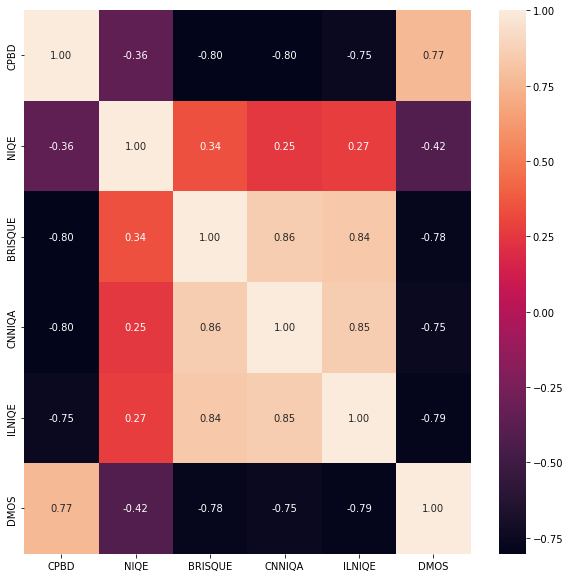

In [305]:
plt.figure(figsize=(10,10))
sns.heatmap(NRIQA_df_last.corr(), annot=True, fmt='.2f')
plt.show()


In [53]:
abs(NRIQA_df_last.corr()).nlargest(9, 'DMOS')['DMOS']    #DMOS와의 상관관계

DMOS            1.000000
ILNIQE          0.788565
BRISQUE         0.780102
CPBD            0.766720
CNNIQA          0.752050
DIQaM_LIVE      0.704602
WaDIQaM_TDI     0.695779
WaDIQaM_LIVE    0.576519
DIQaM_TDI       0.552758
Name: DMOS, dtype: float64

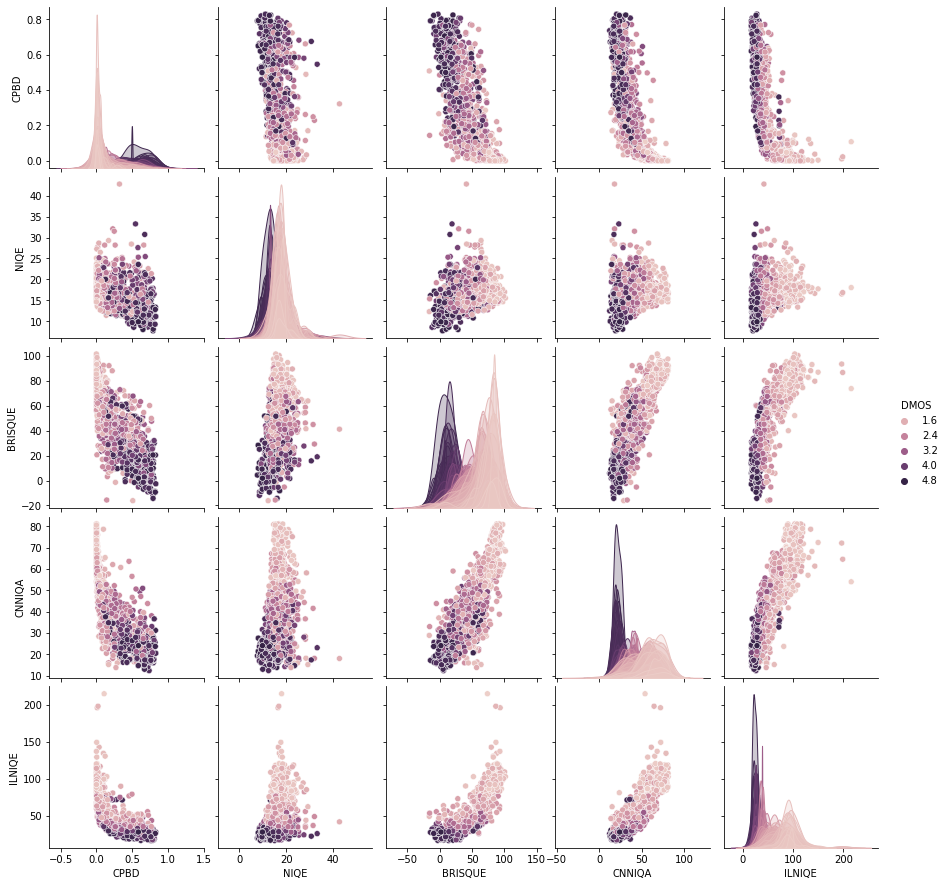

In [369]:
sns.pairplot(data=NRIQA_df_last,hue='DMOS')   #DMOS 분표롤 보면 서로 겹치지 않는 그래프를 보이는 것이 점수가 더 좋음을 알수 있음.

In [69]:
NRIQA_df_last.to_csv("NRIQA_df_last.csv", index=False)

In [67]:
col_list=NRIQA_df_last[['CPBD',	'NIQE',	'BRISQUE',	'CNNIQA',	'ILNIQE',	'WaDIQaM_TID']]

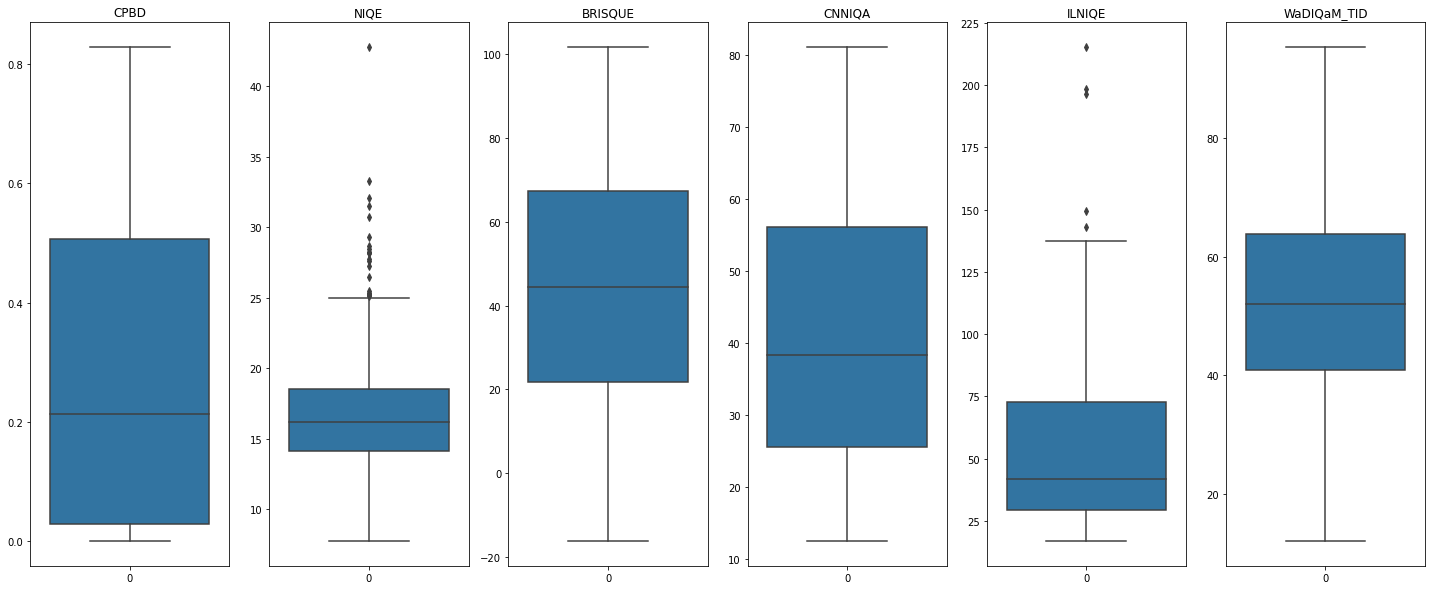

In [68]:
col_list=col_list.columns  #어떤 사진이 이상치에 들어가는지 한번 알아봄 NIQE, ILNIQE 만 이상치가 존재하는 것도 재미있음.
col_list=list(col_list)

plt.figure(figsize=(25,10))
n=1
for i in col_list:
  plt.subplot(1,6,n)
  plt.title(f"{i}")
  sns.boxplot(data=NRIQA_df_last[f'{i}'])
  n+=1
plt.show() 

In [341]:
NRIQA_df_last[NRIQA_df_last['ILNIQE']>140]   #평균범위를 넘어가는 블러효과가 궁금해서 알아봄

,CPBD,NIQE,BRISQUE,CNNIQA,ILNIQE,DMOS,DIST_IMG
94,0.011,16.536,93.630,72.180,196.404,1.37,I07_01_05.png
98,0.038,16.682,79.840,61.385,143.051,1.43,I07_02_04.png
99,0.023,16.869,86.820,64.615,198.445,1.50,I07_02_05.png
1009,0.004,17.745,87.066,72.446,149.603,1.17,I68_01_05.png
1014,0.108,18.061,73.881,54.042,215.344,1.06,I68_02_05.png


In [ ]:
# 그렇다면 Blur 5단계의 평균 ILNIQE 는 어떻까?
# 1_5>2_5>3_5 순서대로 

In [30]:
NRIQA_df_last[NRIQA_df_last['NIQE']>25]['NIQE'].mean()

28.835900000000002

In [35]:
NRIQA_df_last[NRIQA_df_last['DIST_IMG'].str.contains("_05", na=False)]['NIQE'].mean()

17.617403292181073

In [36]:
NRIQA_df_last[NRIQA_df_last['DIST_IMG'].str.contains("_01_05|_02_05", na=False)]['NIQE'].mean()

17.764654320987656

In [37]:
NRIQA_df_last[NRIQA_df_last['DIST_IMG'].str.contains("_01_05", na=False)]['DMOS'].mean()

1.302716049382716

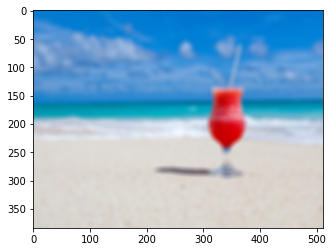

In [21]:
import matplotlib.pyplot as plt
img_color = plt.imread('E:/24team/kadid10k/images/I07_02_04.png')
plt.imshow(img_color)
plt.show()

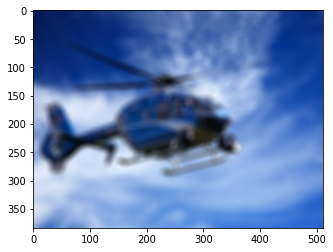

In [13]:
import matplotlib.pyplot as plt
img_color = plt.imread('E:/24team/kadid10k/images/I01_02_05.png')
plt.imshow(img_color)
plt.show()

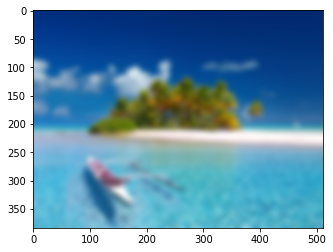

In [22]:
import matplotlib.pyplot as plt
img_color = plt.imread('E:/24team/kadid10k/images/I68_01_05.png')
plt.imshow(img_color)
plt.show()

In [33]:
NRIQA_df_last[['NIQE','DIST_IMG']]

,NIQE,DIST_IMG
0,15.288,I01_01_01.png
1,16.106,I01_01_02.png
2,18.836,I01_01_03.png
3,18.813,I01_01_04.png
4,17.540,I01_01_05.png
...,...,...
1210,9.889,I81_03_01.png
1211,16.853,I81_03_02.png
1212,20.821,I81_03_03.png
1213,18.558,I81_03_04.png


In [34]:
NRIQA_df_last[NRIQA_df_last['NIQE']>25][['NIQE','DIST_IMG']]

,NIQE,DIST_IMG
131,25.462,I09_03_02.png
178,42.770,I12_03_04.png
337,27.732,I23_02_03.png
338,27.263,I23_02_04.png
339,25.087,I23_02_05.png
587,25.228,I40_01_03.png
588,28.681,I40_01_04.png
591,28.200,I40_02_02.png
593,26.486,I40_02_04.png
596,25.311,I40_03_02.png


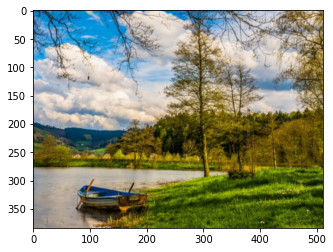

In [41]:
import matplotlib.pyplot as plt   #DMOS 점수는 좋은편이나 NIQE(평균16) 점수는 나쁜 편에 속하는 것을 알수 있음
img_color = plt.imread('E:/24team/kadid10k/images/I09_03_02.png')
plt.imshow(img_color)
plt.show()

In [ ]:
# 이상치에 나오는 것은 정말 매우 안좋거나, 아니면 DMOS와 다른 결과가 나오는 경우임.